In [1]:
import fourier
import data_from_input
from source import source

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
from scipy import constants as const
from numpy.fft import fft, rfft, irfft
from scipy.interpolate import griddata
from scipy import ndimage

from math import floor
import warnings
import struct #для распаковки .bin
import subprocess #для создания списка файлов

In [2]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

## Обобщение на случай падающего сигнала с огибающей в форме гаусса. 

Линейная поляризация

\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \sin{(x_s - t)}= \frac{s}{2}  \frac{\beta_y}{1 - \beta_x} x_s,\quad s = n_0/a \quad \quad (1)
\end{equation}


\begin{equation}
\beta_x^2 + \beta_y^2 = 1 \quad (2)
\end{equation}

$(1)^2$ с учётом $(2)$:
\begin{equation}
e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}  \left(\sin{(x_s - t)}\right)^2= \left(\frac{s}{2}\right)^2  \frac{1-\beta_x^2}{(1 - \beta_x)^2} x_s^2
\end{equation}


\begin{equation}
\frac{dx_s}{dt} =\frac{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}\left(\sin{(x_s - t)}\right)^2 - (sx_s/2)^2}{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}\left(\sin{(x_s - t)}\right)^2 + (sx_s/2)^2}
\end{equation}

Циркулярная поляризация

\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \sin{(x_s - t)}= \frac{s}{2}  \frac{\beta_y}{1 - \beta_x} x_s,\quad s = n_0/a \quad \quad (1)
\end{equation}
\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \cos{(x_s - t)} = \frac{s}{2}  \frac{\beta_z}{1 - \beta_x} x_s \quad \quad (2)
\end{equation}


\begin{equation}
\beta_x^2 + \beta_y^2+ \beta_z^2 = 1 \quad (3)
\end{equation}

$(1)^2 + (2)^2$ с учётом $(3)$:
\begin{equation}
e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}= \left(\frac{s}{2}\right)^2  \frac{1-\beta_x^2}{(1 - \beta_x)^2} x_s^2
\end{equation}


\begin{equation}
\frac{dx_s}{dt} =\frac{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)} - (sx_s/2)^2}{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)} + (sx_s/2)^2}
\end{equation}

In [3]:
def rhs_circ(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2) + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2) + (s/2*x)**2))
    return dxdt

def rhs_lin(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-shift-x))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-shift-x))**2 + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-shift-x))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-shift-x))**2 + (s/2*x)**2))
    return dxdt

def incidence(tt):
    if tt-shift<0:
        dxdt = np.exp((-1)*((tt-shift)/tau)**2)
    else:
        dxdt = np.exp((-1)*((tt-shift)/tau1)**2)
    return dxdt

In [4]:
# для пересчёта в размерные единицы
Omega = 2.35456e+15
LightVelocity = 2.99792e+10

a = 30.0
n_0 = 10.0
s = n_0/a

tau = 20e-15*Omega/np.sqrt(2*np.log(2)) # ширина для переднего фронта
tau1 = 20e-15*Omega/np.sqrt(2*np.log(2)) # ширина для заднего фронта
shift = 2.0*tau # задержка падающего импульса

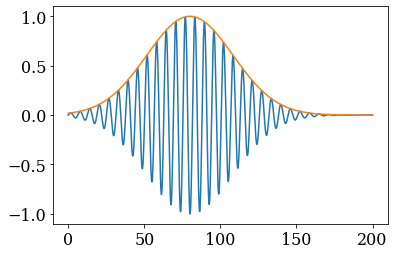

In [5]:
plt.plot(np.arange(0,200,0.01), [incidence(n)*np.sin(n)  for n in np.arange(0,200,0.01)])
plt.plot(np.arange(0,200,0.01), [incidence(n)  for n in np.arange(0,200,0.01)])

In [12]:
Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 29.21 
n_0 = 10.00
s = n_0/a

tau = 3e-15*Omega/np.sqrt(2*np.log(2)) # ширина для переднего фронта
tau1 = 3e-15*Omega/np.sqrt(2*np.log(2)) # ширина для заднего фронта
shift = 1.6*tau # задержка падающего импульса
T = 5.0*tau1 # полное время расчета
dt = 0.00005+5e-8 # шаг по времени
inc_t = 0.0001

#-- расчёт с поиском подходящего шага --#
#-- критерий отбора- глубина отжатия больше 20 нм --#

while True:
    r = ode(rhs_lin).set_integrator('lsoda', rtol = 1.0e-10)
    r.set_initial_value(0, 0)
    x = [0]
    t = [0]
    while r.successful() and r.t < T:
        r.integrate(r.t+dt)
        x.append(r.y[0])
        t.append(r.t)
    if np.max(x)*LightVelocity/Omega*1.e+4 >= 0.05:
        break
    else:
        dt += inc_t
    if dt > 0.03:
        inc_t /= 2
        dt = 0.0005+5e-8
print(dt)

x = np.array(x)
t = np.array(t)
dxdt = np.array([rhs_lin(i,j) for i,j in zip(t,x)])

mask = np.where(x<0)
x[mask] = 1.e-4
dxdt[mask] = -1.e-4

#-- находим отраженное поле --#
beta_z = np.zeros(len(t)-1)
for i in range(1, len(t)-1):
    if t[i]-shift-x[i]<0:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau) **2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
    else:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau1)**2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
az_r = n_0/2*beta_z/(1+dxdt[1:])*x[1:]
az_r = griddata((t[1:] + x[1:]), az_r, t[1:], method = "cubic")

az_i = np.array([a*incidence(n)*np.sin(n)  for n in t]) # падающее поле

5.0050000000000004e-05


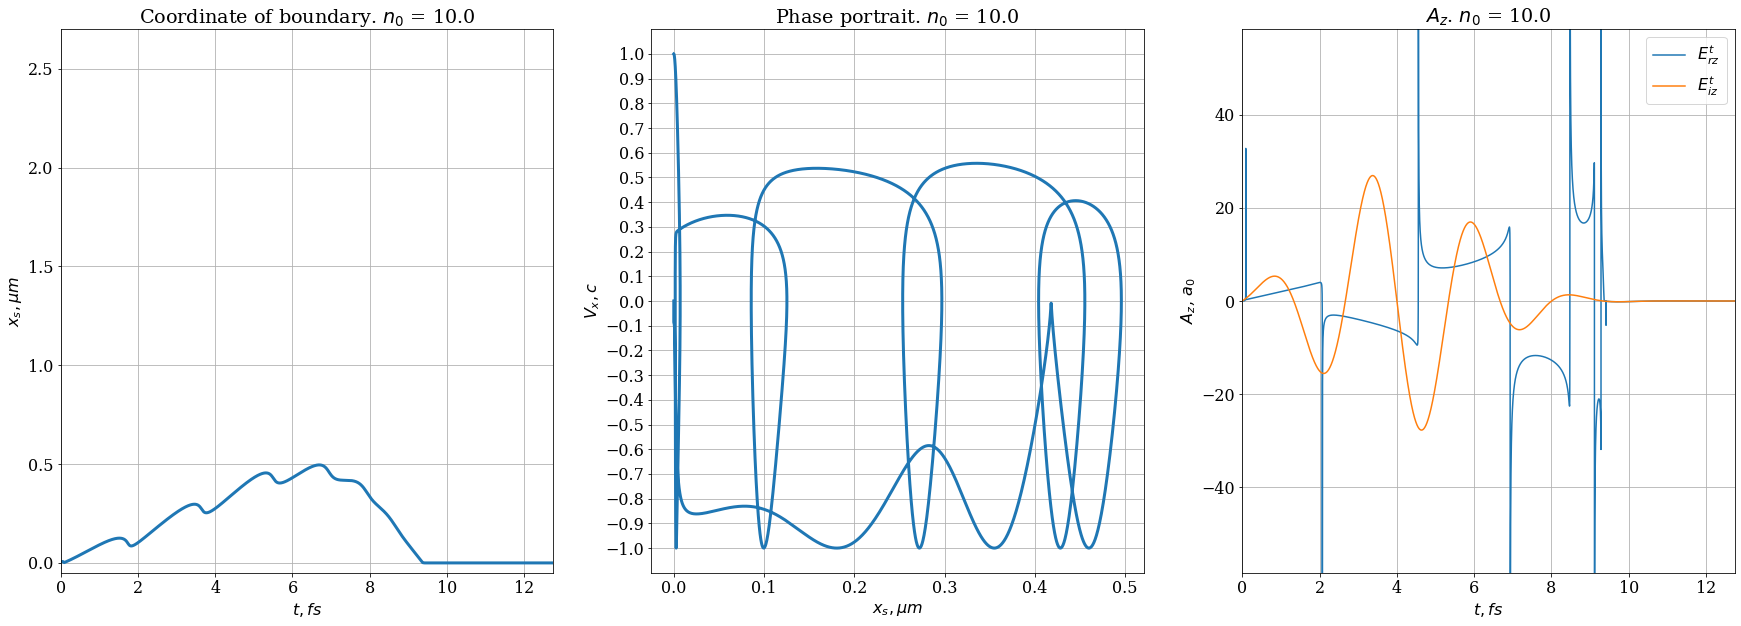

In [13]:
max_t = T/Omega*1.e+15
max_x = 2.7

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30,10))
#plt.figure(figsize = (5,5))
ax1.plot(t[:]/Omega*1.e+15, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0)
ax1.set_xlabel(r"$t, fs$")
ax1.set_ylabel(r"$x_s, \mu m$")
ax1.set_title("Coordinate of boundary." + r" $n_0$ = {}".format(n_0))
ax1.grid()
ax1.axis([0, max_t, -0.05, max_x])
#plt.show()

#plt.figure(figsize = (5,5))
ax2.plot(x[:]*LightVelocity/Omega*1.e+4, dxdt[:], linewidth = 3.0)
ax2.set_xlabel(r"$x_s, \mu m$")
ax2.set_ylabel(r"$V_x, c$")
ax2.set_yticks(np.arange(-1.0,1.1,0.1))
ax2.set_title("Phase portrait." + r" $n_0$ = {}".format(n_0))
ax2.grid()
#plt.show()

#plt.figure(figsize = (5,5))
ax3.plot((t[1:])/Omega*1.e+15, az_r[:], label = r'$E^t_{rz}$', linewidth = 1.5)
ax3.plot(t[:]/Omega*1.e+15, az_i, label = r'$E^t_{iz}$', linewidth = 1.5)
ax3.set_title("$A_z$." + r" $n_0$ = {}".format(n_0))
ax3.set_xlabel(r"$t, fs$")
ax3.set_ylabel(r"$A_z$, $a_0$")
ax3.axis([0, max_t, -2*a, +2*a])
ax3.legend()
ax3.grid()
#plt.show()

In [16]:
name = r"./data/source/l_long_70.0_2021-06-28_10-40-04"
name = r"./data/source/l_long_30.0_2021-07-05_10-17-17"
name = r"/media/nikita/Test/midIR/1D/source/energy_n30_big_2022-05-12_16-34-47"
#name = r"/home/nikita/Documents/science/disk_backup/1D/linear_smalltail/l_long_30.0_2021-07-05_10-17-17"
n_0 = 30.0

l = subprocess.check_output(['ls',], cwd = name+ r'/BasicOutput/data/by2dxy')
files = l.split()
files = [i.decode('ascii') for i in files]
#print(files)

In [17]:
def reparse1(files, name, field, norm):
    bz = []
    for file in files:
        with open(name +r"/BasicOutput/data/" + field + "/" + file, mode = "rb") as f:
            line_of_data = np.frombuffer(f.read(), dtype = np.float32)
            #by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField
            bz.append(line_of_data/norm)
    return bz

In [18]:
Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 27.8508
#a = 75.21

RelativisticField = 1.33872e+08
FocalSpotWidthFWHM = 5e-4
LightVelocity = 2.99792e+10

ElectronsPerCell = 6.53235e+15/5

delta_t, delta_x, a_rel, n, focal_spot_fwhm = data_from_input.parameters_from_input(name)

In [19]:
bz, x_array = data_from_input.reparse(name, "bz2dxy",a_rel, delta_x)
by = np.array(reparse1(files, name, "by2dxy",a_rel))
ey = np.array(reparse1(files, name, "ey2dxy",a_rel))
ez = np.array(reparse1(files, name, "ez2dxy",a_rel))

by_r = ((ez+by)/2)
by_i = ((-ez+by)/2)

bz_r = ((-ey+bz)/2)
bz_i = ((ey+bz)/2)

del ez,by,ey,bz

n_e = data_from_input.reparse(name, "electron2dxy", n, 0)

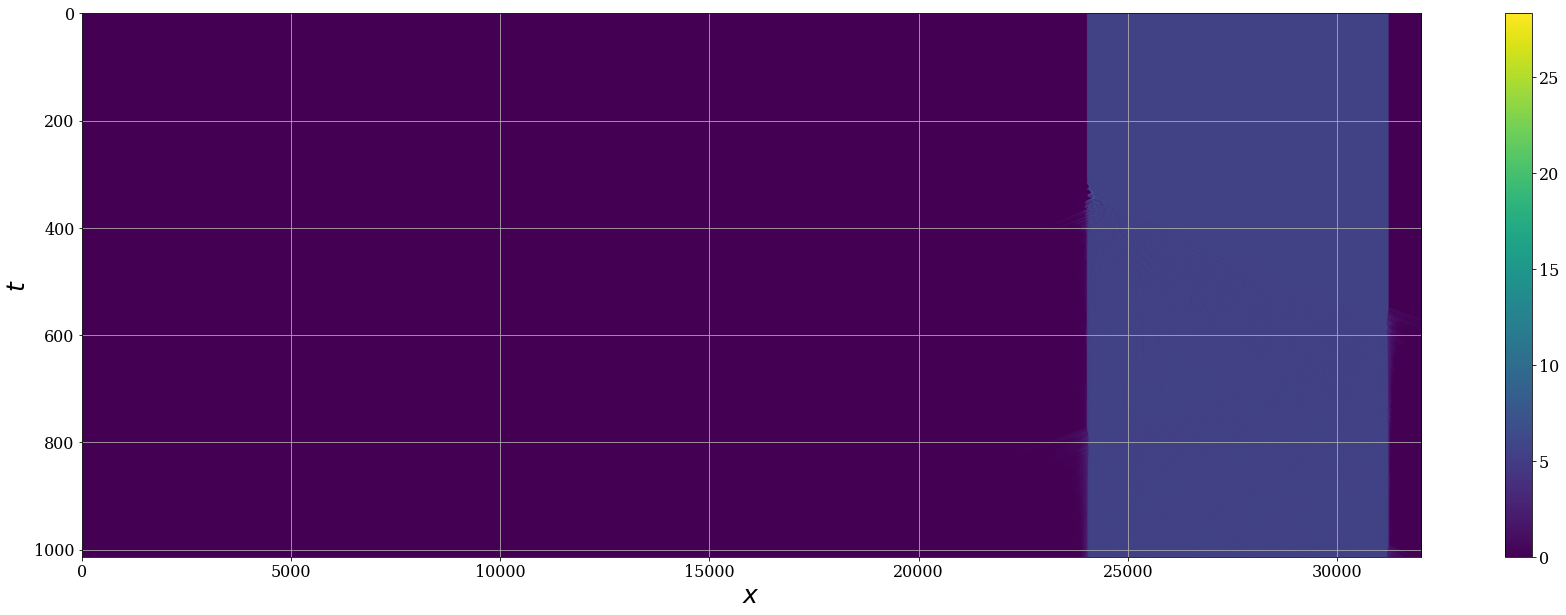

In [20]:
fig = plt.figure(figsize=(30,10))
plt.imshow(np.sqrt(n_e), aspect = "auto")
ax = plt.gca();
plt.xlabel(r"$x$", fontsize=25)
plt.ylabel(r"$t$", fontsize=25)
cbar = plt.colorbar()
#cbar.set_label(r"$E_t = \sqrt{E_y^2 + E_z^2}, E_r$")
#ax.set_xticks(np.arange(2000,5100,100))
#ax.set_yticks(np.arange(0,1000,20))
ax.grid()
#plt.axis([2000, 4000, 1000, 0])
plt.show()

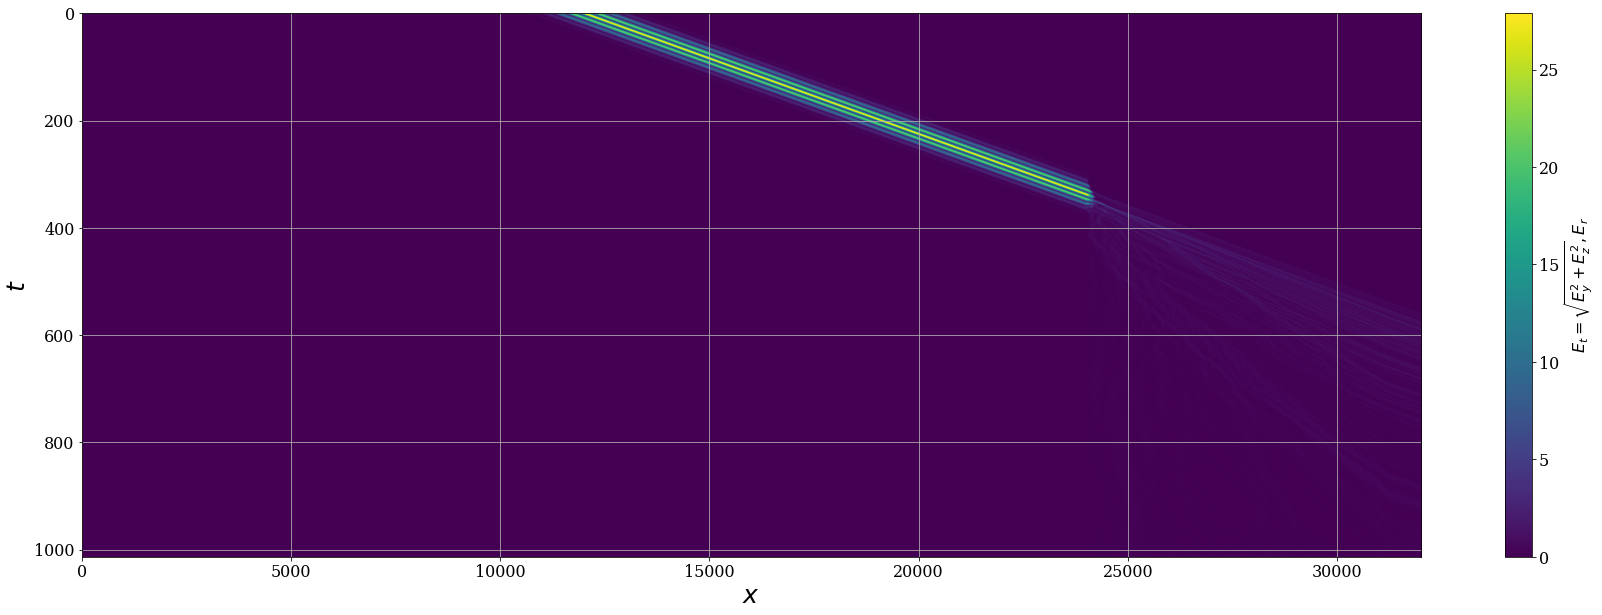

In [21]:
fig = plt.figure(figsize=(30,10))
plt.imshow(np.sqrt(bz_i**2 + by_i**2), aspect = "auto")
ax = plt.gca();
plt.xlabel(r"$x$", fontsize=25)
plt.ylabel(r"$t$", fontsize=25)
cbar = plt.colorbar()
cbar.set_label(r"$E_t = \sqrt{E_y^2 + E_z^2}, E_r$")
#ax.set_xticks(np.arange(2000,5100,100))
#ax.set_yticks(np.arange(0,1000,20))
ax.grid()
#plt.axis([2000, 4000, 1000, 0])
plt.show()

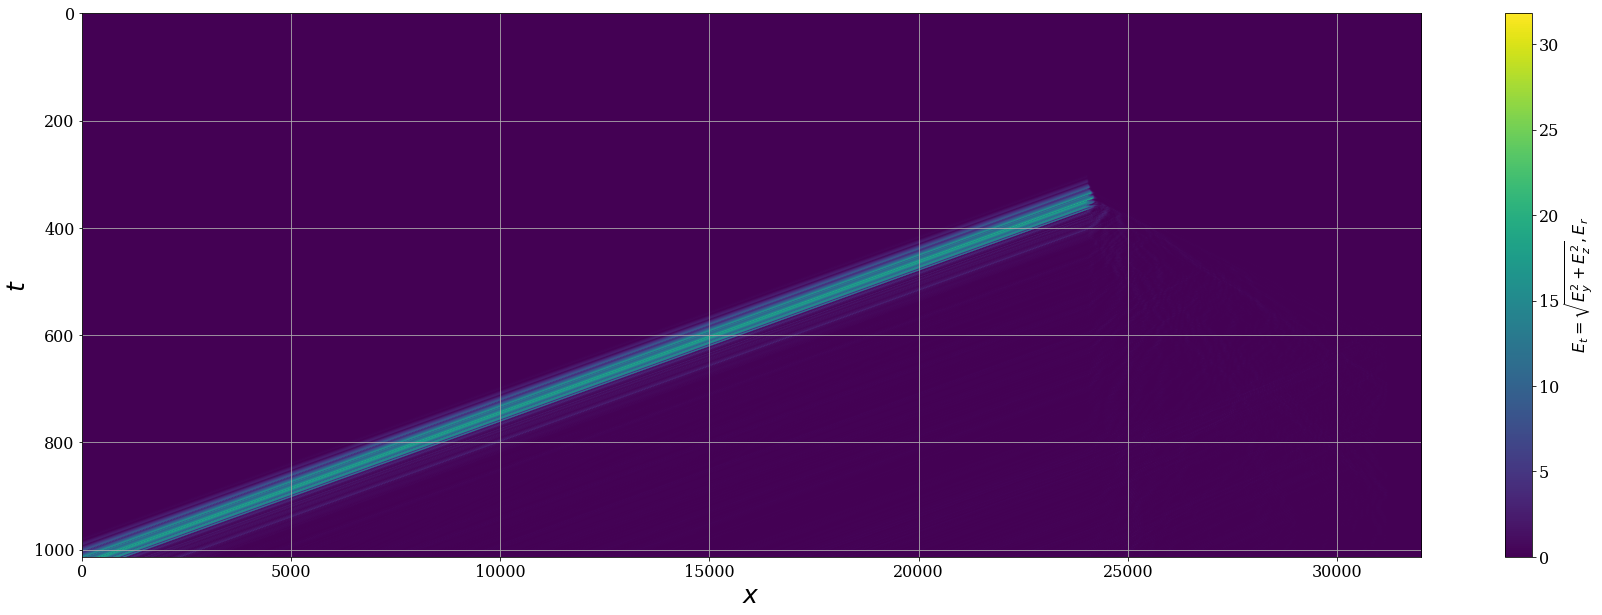

In [22]:
fig = plt.figure(figsize=(30,10))
plt.imshow(np.sqrt(bz_r**2 + by_r**2), aspect = "auto")
ax = plt.gca();
plt.xlabel(r"$x$", fontsize=25)
plt.ylabel(r"$t$", fontsize=25)
cbar = plt.colorbar()
cbar.set_label(r"$E_t = \sqrt{E_y^2 + E_z^2}, E_r$")
#ax.set_xticks(np.arange(2000,5100,100))
#ax.set_yticks(np.arange(0,1000,20))
ax.grid()
#plt.axis([2000, 4000, 1000, 0])
plt.show()

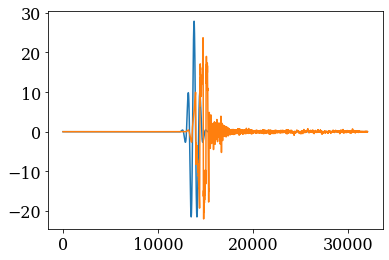

In [23]:
plt.plot(bz_i[50,:])
plt.plot(bz_r[610,:])

In [183]:
mask_2d = np.where((np.sqrt(bz_r**2 + by_r**2) > 5e-3), 1, 0)
mask_ne = np.where(n_e > 9e-1, 0.99, 0.01)

In [261]:
def filter_gauss(w, shift, sigma):
    return np.exp(-((w-shift)/sigma)**2/2)

field_r = (bz_r)[610,:]
field_i = (bz_i)[50,:]
filter_range = (3, 10)

rfft_i = abs(np.fft.rfft(field_i))
argmax = np.argmax(rfft_i)

k_x = np.arange(np.shape(rfft_i)[0])/argmax
lambda_i = 0.8/k_x[1:]
filter_range_i = (np.where(lambda_i>filter_range[1])[0][-1], np.where(lambda_i>filter_range[0])[0][-1])

filtered_fft_r = np.zeros(np.shape(abs(np.fft.rfft(field_r))), dtype = "complex")
#filtered_fft_r[filter_range_i[0]:filter_range_i[1]] = (np.fft.rfft(field_r, axis = 0))[filter_range_i[0]:filter_range_i[1]]
filter_shape = filter_gauss(np.arange(len(filtered_fft_r)), sum(filter_range_i)/2, (filter_range_i[1] - filter_range_i[0])/2)
#filter_shape[filter_range_i[0]:int(sum(filter_range_i)/2)] = abs(np.ones(len(field_r)))[filter_range_i[0]:int(sum(filter_range_i)/2)]
#filter_shape[0:filter_range_i[0]] = 0
filtered_fft_r = np.fft.rfft(field_r)*filter_shape
filtered_r = np.fft.irfft(filtered_fft_r)
t1 = np.linspace(0,150, 5*len(filtered_r))

(0.0, 60.0)

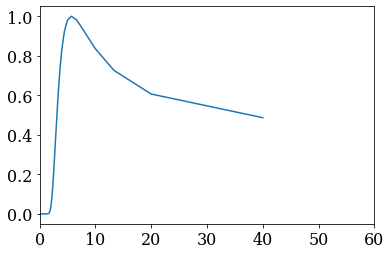

In [262]:
plt.plot(lambda_i,filter_shape[1:])
plt.xlim(0,60)
#plt.plot(filter_shape)

In [263]:
t2 = np.linspace(0,40, len(field_i))-30
dtt = t2[2]-t2[1]
t1 = np.arange(0,40, dtt)-30

In [269]:
field_i.shape

(32000,)

In [270]:
def filter_gauss(w, shift, sigma):
    return np.exp(-((w-shift)/sigma)**2/2)

#field_r = (bz_r)[610,:]
#field_i = (bz_i)[50,:]
rfft_i = abs(np.fft.rfft(field_i))
argmax = np.argmax(rfft_i)

k_x = np.arange(np.shape(rfft_i)[0])/argmax
lambda_i = 0.8/k_x[1:]
filter_range = np.where((k_x<200) &(k_x>50),1,0)

filtered_fft_r = np.fft.rfft(field_r)*filter_range
filtered_r_h = np.fft.irfft(filtered_fft_r)
#filter_shape = np.where((lambda_i>filter_range[1])|(lambda_i<filter_range[0]),0,1)
#t11 = np.linspace(0,150*61/100, 5*len(filtered_r_h))

In [271]:
filter_range_i

(2, 12)

(0.0, 1.0)

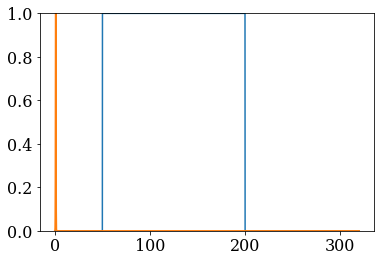

In [272]:
plt.plot(k_x,filter_range)
plt.plot(k_x,rfft_i/10000)
#plt.xlim(0,100)
plt.ylim(0,1)
#plt.plot(filter_shape)

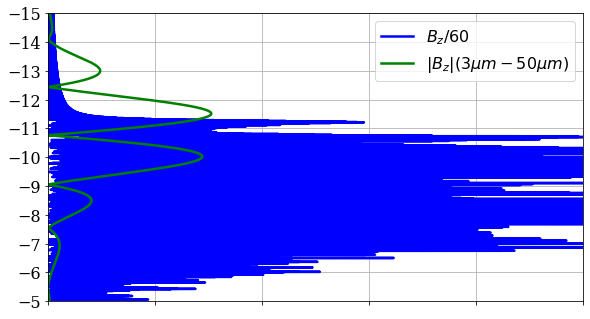

In [273]:
fig = plt.figure(figsize = (15,20))

yticks = np.arange(-30,10,1)
ax2 = plt.axes([0.125, 0.88, 0.4957, 0.2])
ax2.plot(np.abs(filtered_r_h),t1[:]+1, linewidth = 2.5, c = "b", label = r'$B_z/60$'.format(range1[0], range1[1]))
ax2.plot(np.abs(filtered_r),t1[:]+1, linewidth = 2.5, c = "g", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
#ax2.plot(t1+21.5, np.abs(filtered_r_h), linewidth = 2.5, c = "b", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
#ax2.set_xticks(np.arange(0,200,10))
ax2.set_yticks(yticks)
ax2.axis([0.0,0.5,-5, -15])
ax2.set_xticklabels([])
#ax2.set_yticklabels(["",] + str_yticks[1:])
ax2.legend(loc = "best")
ax2.grid()

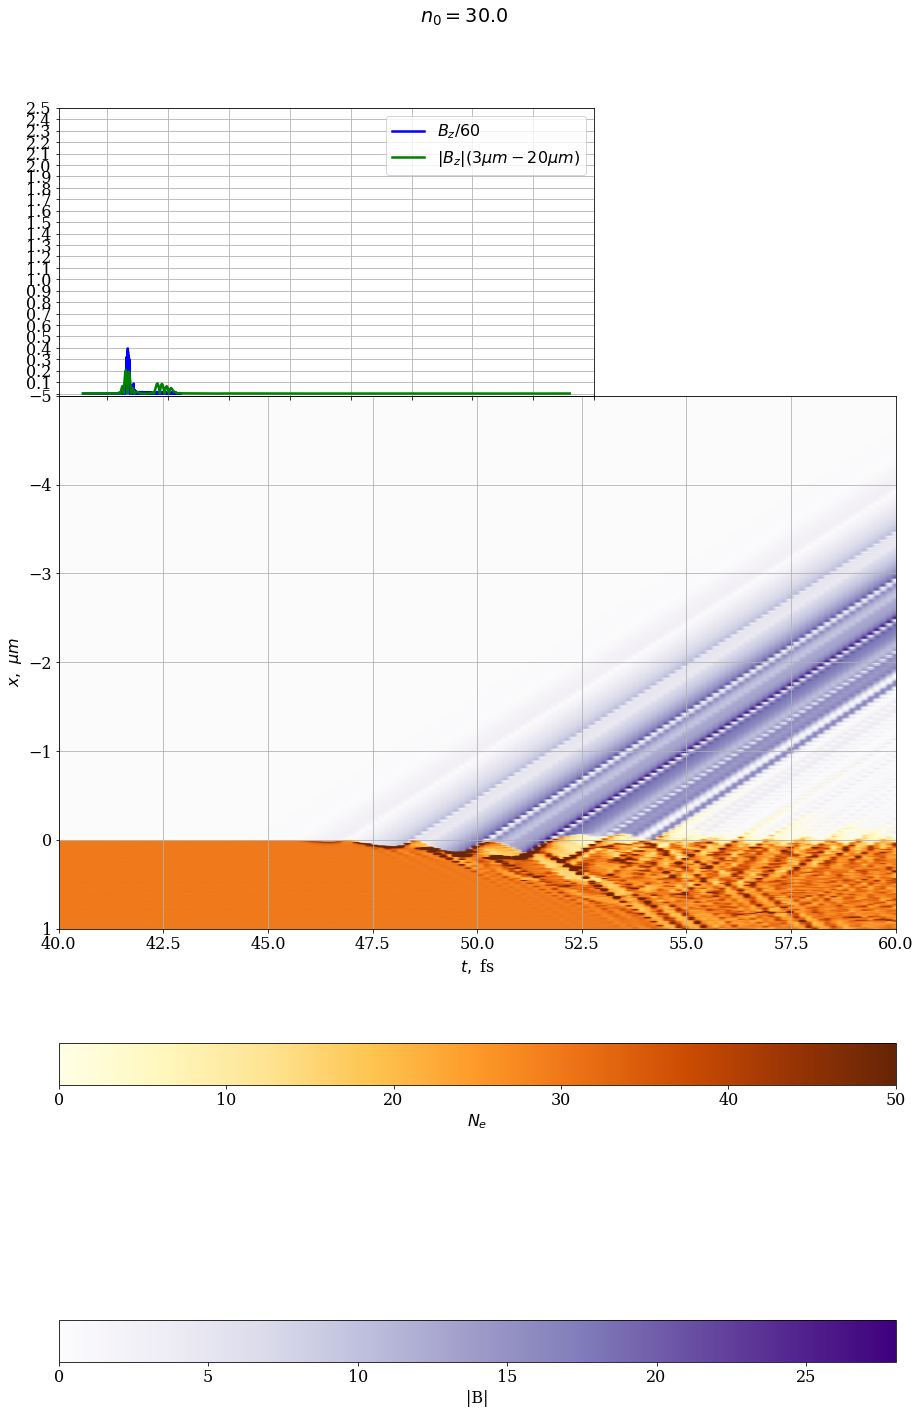

In [92]:
fig = plt.figure(figsize = (15,20))


fig.suptitle("$n_0 = {}$".format(n_0), y = 1.15)
ax1 = plt.axes()  # standard axes

imag3 = ax1.imshow(n_e.T, vmax = 50, vmin = 0, cmap = "YlOrBr", extent = (0, 150, 10, -30), aspect =  "auto")
imag1 = ax1.imshow(abs(bz_r.T), vmax = 28, vmin = 0, cmap = "Purples", extent = (0, 150, 10, -30), aspect = "auto")
cbar1 = fig.colorbar(imag1, orientation="horizontal")
cbar2 = fig.colorbar(imag3, orientation="horizontal")
cbar1.set_label("|B|")
cbar2.set_label(r'$N_e$')
imag2 = ax1.imshow(n_e.T, alpha = mask_ne.T, vmax = 50, vmin = 0, cmap = "YlOrBr", extent = (0, 150, 10, -30), aspect =  "auto")

#plt.plot(t[:]/Omega*1.e+15 + 36.0, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0, c = "#76C8F7")

ax1.axis([40, 60, 1, -5])

plt.xlabel("$t,$ fs")
plt.ylabel("$x,$ $\mu m$")
ax1.grid()

yticks = np.arange(0,2.6*10,0.1*10)/10
str_yticks = [str(i) for i in yticks]

ax2 = plt.axes([0.125, 0.88, 0.4957, 0.2])
ax2.plot(t2, abs(field_r)/60, linewidth = 2.5, c = "b", label = r'$B_z/60$'.format(range1[0], range1[1]))
ax2.plot(t1, np.abs(filtered_r), linewidth = 2.5, c = "g", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
#ax2.plot(t1+21.5, np.abs(filtered_r_h), linewidth = 2.5, c = "b", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
#ax2.set_xticks(np.arange(0,200,10))
ax2.set_yticks(yticks)
#ax2.axis([5, 15,0.0,0.5])
ax2.set_xticklabels([])
ax2.set_yticklabels(["",] + str_yticks[1:])
ax2.legend(loc = "best")
ax2.grid()



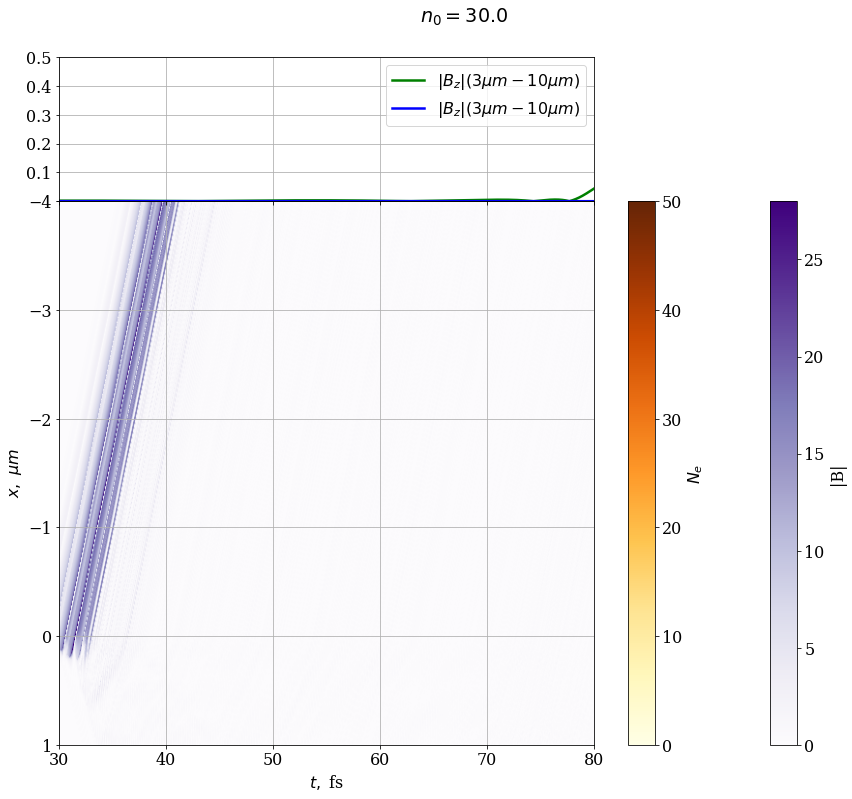

In [50]:
fig = plt.figure(figsize = (15,10))


fig.suptitle("$n_0 = {}$".format(n_0), y = 1.15)
ax1 = plt.axes()  # standard axes

imag3 = ax1.imshow(n_e.T, vmax = 50, vmin = 0, cmap = "YlOrBr", extent = (0, 150*61/100, 10, -30), aspect =  "auto")
imag1 = ax1.imshow(abs(bz_r.T), vmax = 28, vmin = 0, cmap = "Purples", extent = (0, 150*61/100, 10, -30), aspect = "auto")
cbar1 = fig.colorbar(imag1)
cbar2 = fig.colorbar(imag3)
cbar1.set_label("|B|")
cbar2.set_label(r'$N_e$')
#imag2 = ax1.imshow(n_e.T, alpha = mask_ne.T, vmax = 50, vmin = 0, cmap = "YlOrBr", extent = (0, 150*61/100, 10, -30), aspect =  "auto")

#plt.plot(t[:]/Omega*1.e+15 + 36.0, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0, c = "#76C8F7")

ax1.axis([30, 80, 1, -4])

plt.xlabel("$t,$ fs")
plt.ylabel("$x,$ $\mu m$")
ax1.grid()

yticks = np.arange(0,2.6*10,0.1*10)/10
str_yticks = [str(i) for i in yticks]

ax2 = plt.axes([0.125, 0.88, 0.4957, 0.2])
#ax2.plot(t2+21.5, abs(field_r)/60, linewidth = 2.5, c = "b", label = r'$B_z/60$'.format(range1[0], range1[1]))
ax2.plot(t1+21.5, np.abs(filtered_r), linewidth = 2.5, c = "g", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
ax2.plot(t1+21.5, np.abs(filtered_r_h)/20, linewidth = 2.5, c = "b", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
ax2.set_xticks(np.arange(0,200,10))
ax2.set_yticks(yticks)
ax2.axis([30, 80,0.0,0.5])
ax2.set_xticklabels([])
ax2.set_yticklabels(["",] + str_yticks[1:])
ax2.legend(loc = "best")
ax2.grid()



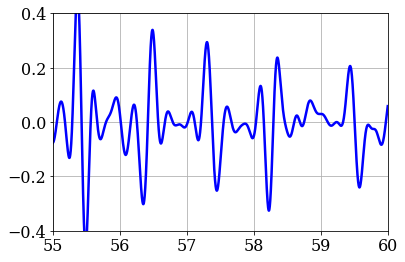

In [28]:
plt.plot(t1+21.5, (filtered_r_h)/20, linewidth = 2.5, c = "b", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
plt.axis([55, 60,-0.4,0.4])
plt.grid()

In [17]:
name = r"./data/source/l_steep_70.0_2021-06-28_10-40-06"
name = r"./data/source//l_long_70.0_2021-07-05_10-17-19"
#name = r"/home/nikita/Documents/science/disk_backup/1D/linear_smalltail/l_long_70.0_2021-07-05_10-17-19"
n_0 = 70.0

l = subprocess.check_output(['ls',], cwd = name+ r'/BasicOutput/data/by2dxy')
files = l.split()
files = [i.decode('ascii') for i in files]
#print(files)

def reparse1(files, name, field, norm):
    bz = []
    for file in files:
        with open(name +r"/BasicOutput/data/" + field + "/" + file, mode = "rb") as f:
            line_of_data = np.frombuffer(f.read(), dtype = np.float32)
            #by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField
            bz.append(line_of_data/norm)
    return bz

Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 27.8508

RelativisticField = 1.33872e+08
FocalSpotWidthFWHM = 5e-4
LightVelocity = 2.99792e+10

ElectronsPerCell = 6.53235e+15/5

delta_t, delta_x, a_rel, n, focal_spot_fwhm = data_from_input.parameters_from_input(name)

bz, x_array = data_from_input.reparse(name, "bz2dxy",a_rel, delta_x)
by = np.array(reparse1(files, name, "by2dxy",a_rel))
ey = np.array(reparse1(files, name, "ey2dxy",a_rel))
ez = np.array(reparse1(files, name, "ez2dxy",a_rel))

n_e = data_from_input.reparse(name, "electron2dxy", n, 0)

by_r = (ez+by)/2
by_i = (-ez+by)/2

bz_r = (-ey+bz)/2
bz_i = (ey+bz)/2

mask_2d = np.where((np.sqrt(bz_r**2 + by_r**2) > 5e-3), 1, 0)
mask_ne = np.where(n_e > 9e-1, 0.99, 0.01)

In [75]:
def filter_gauss(w, shift, sigma):
    return np.exp(-((w-shift)/sigma)**2/2)

range1 = (3, 10)

field_r = (bz_r)[:,6500]
filter_range = range1

rfft_i = abs(np.fft.rfft(bz_i, axis = 0))
argmax = np.unravel_index(np.argmax(rfft_i, axis = None), rfft_i.shape)[0]

k_x = np.arange(1,np.shape(rfft_i)[0])/argmax
lambda_i = 0.8/k_x
filter_range_i = (np.where(lambda_i>filter_range[1])[0][-1], np.where(lambda_i>filter_range[0])[0][-1])

filtered_fft_r = np.zeros(np.shape(abs(np.fft.rfft((field_r)))), dtype = "complex")
#filtered_fft_r[filter_range_i[0]:filter_range_i[1]] = (np.fft.rfft(field_r, axis = 0))[filter_range_i[0]:filter_range_i[1]]

filter_shape = filter_gauss(np.arange(len(filtered_fft_r)), sum(filter_range_i)/2, (filter_range_i[1] - filter_range_i[0])/1)
filter_shape[filter_range_i[0]:int(sum(filter_range_i)/2)] = abs(np.ones(len(field_r)))[filter_range_i[0]:int(sum(filter_range_i)/2)]
filter_shape[0:filter_range_i[0]] = 0
filtered_fft_r = np.fft.rfft(field_r, axis = 0)*filter_shape
filtered_r = np.fft.irfft(filtered_fft_r, axis = 0)
t1 = np.linspace(0,200, filtered_r.shape[0])

(-0.1, 16.0, 0.0, 1.1)

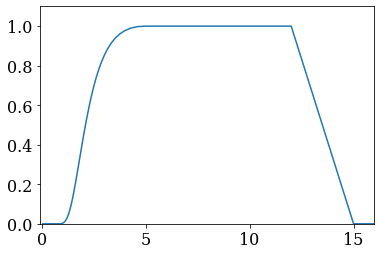

In [76]:
plt.plot(lambda_i ,filter_shape[:-1])
plt.axis([-0.1,16,0,1.1])

In [77]:
def rhs_circ(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2) + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2) + (s/2*x)**2))
    return dxdt

def rhs_lin(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-x+1e-4))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-x+1e-4))**2 + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-x+1e-4))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-x+1e-4))**2 + (s/2*x)**2))
    return dxdt

def incidence(tt):
    if tt-shift<0:
        dxdt = np.exp((-1)*((tt-shift)/tau)**2)
    else:
        dxdt = np.exp((-1)*((tt-shift)/tau1)**2)
    return dxdt

In [78]:
a = 27.85
n_0 = 70.0
s = n_0/a

tau = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для переднего фронта
tau1 = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для заднего фронта
shift = 1.4*tau # задержка падающего импульса
T = 10*tau1 # полное время расчета
dt = 0.002 # шаг по времени

#-- расчёт с поиском подходящего шага --#
#-- критерий отбора- глубина отжатия больше 20 нм --#

while True:
    r = ode(rhs_lin).set_integrator('lsoda', rtol = 1.0e-10)
    r.set_initial_value(0, 0)
    x = [0]
    t = [0]
    while r.successful() and r.t < T:
        r.integrate(r.t+dt)
        x.append(r.y[0])
        t.append(r.t)
    if np.max(x)*LightVelocity/Omega*1.e+4 >= 0.02:
        break
    else:
        dt += 0.0001
print(dt)

0.0033999999999999976


In [79]:
x = np.array(x)
t = np.array(t)
dxdt = np.array([rhs_lin(i,j) for i,j in zip(t,x)])

mask = np.where(x<0)
x[mask] = 1.e-4
dxdt[mask] = -1.e-4

#-- находим отраженное поле --#
beta_z = np.zeros(len(t)-1)
for i in range(1, len(t)-1):
    if t[i]-shift-x[i]<0:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau) **2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
    else:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau1)**2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
az_r = n_0/2*beta_z/(1+dxdt[1:])*x[1:]
az_r = griddata((t[1:] + x[1:]), az_r, t[1:], method = "cubic")

az_i = np.array([a*incidence(n)*np.sin(n)  for n in t]) # падающее поле

In [81]:
fft_r = np.fft.fftshift(np.fft.fft2(bz_r))
fft_i = np.fft.fftshift(np.fft.fft2(bz_i))

freq_x = (np.arange(fft_i.shape[1]) - fft_i.shape[1]/2) / (np.unravel_index(np.argmax(abs(fft_i)), fft_i.shape)[1]-fft_i.shape[1]/2)
freq_y = (np.arange(fft_i.shape[0]) - fft_i.shape[0]/2) / (np.unravel_index(np.argmax(abs(fft_i)), fft_i.shape)[0]-fft_i.shape[0]/2)

w_x, w_y = np.meshgrid(freq_x, freq_y)

uniform_filter = ndimage.fourier_gaussian(np.fft.fft2(bz_r), sigma= 0.2)

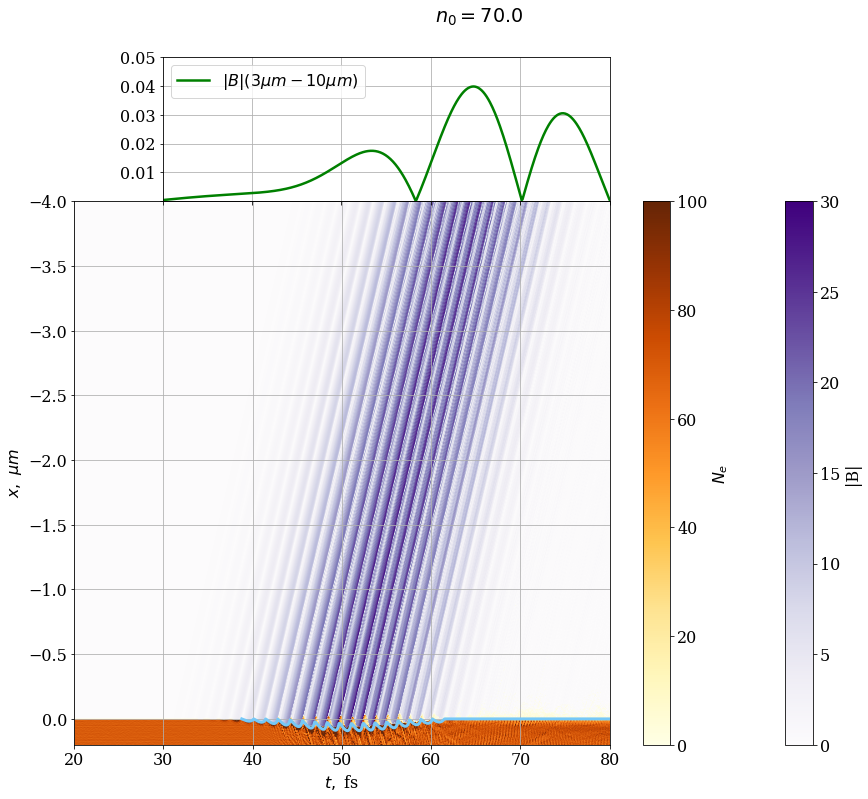

In [88]:
fig = plt.figure(figsize = (15,10))


fig.suptitle("$n_0 = {}$".format(n_0), y = 1.15)
ax1 = plt.axes()  # standard axes

imag3 = ax1.imshow(n_e.T, vmax = 100, vmin = 0, cmap = "YlOrBr", extent = (0, 200, 10, -30), aspect =  "auto")

imag1 = ax1.imshow(abs(bz_r.T), vmax = 30, vmin = 0, cmap = "Purples", extent = (0, 200, 10, -30), aspect = "auto")
#imag1 = ax1.imshow((np.sqrt((filtered_bz_r1)**2)).T, vmax = 1, vmin = 0, cmap = "BuGn", extent = (0, 400, 30, -30), aspect = "auto")
cbar1 = fig.colorbar(imag1)
cbar2 = fig.colorbar(imag3)
cbar1.set_label("|B|")
cbar2.set_label(r'$N_e$')
imag2 = ax1.imshow(n_e.T, alpha = mask_ne.T, vmax = 100, vmin = 0, cmap = "YlOrBr", extent = (0, 200, 10, -30), aspect =  "auto")

#ax1.set_xticks(np.arange(0,50,5))

plt.plot(t[:]/Omega*1.e+15 + 38.8, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0, c = "#76C8F7")

ax1.axis([20, 80, 0.2, -4])
plt.xlabel("$t,$ fs")
plt.ylabel("$x,$ $\mu m$")
ax1.grid()

#-----------------2-----------------------#
yticks = np.arange(0,1.0*10,0.01*100)/100
str_yticks = [str(i) for i in yticks]

ax2 = plt.axes([0.207, 0.88, 0.414, 0.2])
#ax2.plot(t, ((np.sqrt((filtered_bz_r1)**2)))[:,3466], linewidth = 2.5, c = "g", label = "|B|")

ax2.plot(t1+3, abs(filtered_bz_r1[:,6500]), linewidth = 2.5, c = "g", label = r'$|B|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))

#ax2.plot(t, abs(filtered_bz_r1[:,2666]), linewidth = 1.5, label = "|B$_z$|")
#ax2.plot(t, abs((filtered_bz_r1)[:,2666]), linewidth = 1.5, label = "|B$_z$|")
ax2.set_xticks(np.arange(0,200,10))
ax2.set_yticks(yticks)
ax2.axis([30, 80,0.0,0.05])
ax2.set_xticklabels([])
ax2.set_yticklabels(["",] + str_yticks[1:])
ax2.legend()
ax2.grid()